Part 2: Data analysis with Matplotlib

(A) **Produce at least two figures that illustrate the max. temperature distribution over the entire globe and enable a comparison of different non-overlapping time periods. Only show temperatures where you have data available.**

In [ ]:
inputs = 'tmax-2/'

In [157]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Row, functions, Column
from pyspark.sql.types import *
from pyspark.sql import functions
import sys

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import pandas as pd


spark = SparkSession.builder.appName('weather related prediction').getOrCreate()
assert sys.version_info >= (3, 5)  # make sure we have Python 3.5+
assert spark.version >= '2.2'  # make sure we have Spark 2.2+

schema = StructType([
	StructField('station', StringType(), False),
	StructField('date', DateType(), False),
	# StructField('dayofyear', IntegerType(), False),
	StructField('latitude', FloatType(), False),
	StructField('longitude', FloatType(), False),
	StructField('elevation', FloatType(), False),
	StructField('tmax', FloatType(), False),
])


#### plotting using plotly ########
def plotData(df, title):
	data = [ dict(
			type = 'scattergeo',
			lon = df['lon'],
			lat = df['lat'],
			text = df['station'],
			mode = 'markers',
			marker = dict(
				size = 4,
				opacity = 0.7,
				reversescale = False,
				autocolorscale = False,
				symbol = 'circle',
				line = dict(
					width=1,
					color='rgba(102, 102, 102)'
				),
				cmin = df['tmax'].min(),
				color = df['tmax'],
				cmax = df['tmax'].max(),
				colorbar=dict(
					title="Temparature in C"
				)
			))]

	layout = dict(
			title = title,
			# colorbar = True,
			geo = dict(
				scope='world',
				# projection=dict( type='orthographic', rotation= dict(lat=40, lon= -100, roll=0) ),
				projection=dict( type='equirectangular'),
				showland = True,
				landcolor = "rgb(250, 250, 250)",
				subunitcolor = "rgb(217, 217, 217)",
				countrycolor = "rgb(217, 217, 217)",
				countrywidth = 0.5,
				subunitwidth = 0.5
			),
		)
	

	fig = dict( data=data, layout=layout )
	plot(fig)

def get_data(inputloc, tablename='data'):
	data = spark.read.csv(inputloc, schema=schema)
	data.createOrReplaceTempView(tablename)
	return data

def year_data(dataWithYear, yr):
	dataWithYear = dataWithYear.where(dataWithYear['Year'] == yr)
	grouped = dataWithYear.groupBy(dataWithYear['station']).agg(functions.max(dataWithYear['tmax']).alias('max_temp'))
	grouped = grouped.withColumnRenamed('station','stn')
	cond = (dataWithYear['tmax'] == grouped['max_temp']) & (dataWithYear['station'] == grouped['stn'])
	joined = dataWithYear.join(grouped,cond).select('stn','max_temp','latitude','longitude','elevation')
	return joined.drop_duplicates().toPandas()


In [159]:
## Produce plots for Part - A
# output = None
colnames = ["station", "tmax", "lat", "lon", "elevation"]

data = get_data(inputs)
date_contents = functions.split(data['date'],'-')
dataWithYear = data.withColumn('Year', date_contents.getItem(0).cast(IntegerType()))

data_04 = year_data(dataWithYear=dataWithYear, yr=2004)
data_04.columns= colnames
plotData(data_04, 'Temperature Distribution for 2004')

data_05 = year_data(dataWithYear=dataWithYear, yr=2015)
data_05.columns= colnames
plotData(data_05, 'Temperature Distribution for 2015')

**B1 : Evaluate your model at a grid of latitude, longitude positions around the globe leading to a dense plot of temperatures that includes oceans. This could, for instance, look something like the following and may have some gaps, if you decide not to interpolate between grid points:**

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Row, functions, Column
from pyspark.sql.types import *

from pyspark.ml import Pipeline, Estimator
from pyspark.ml.feature import SQLTransformer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.regression import (LinearRegression,
                                   GBTRegressor,
                                   RandomForestRegressor,
                                   DecisionTreeRegressor)
import sys
from weather_tools import *

# import elevation_grid as eg
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.mlab import griddata

from datetime import datetime

%matplotlib inline

In [ ]:
spark = SparkSession.builder.appName('weather related prediction').getOrCreate()
assert sys.version_info >= (3, 5)  # make sure we have Python 3.5+
assert spark.version >= '2.2'  # make sure we have Spark 2.2+

In [ ]:
schema = StructType([
    StructField('station', StringType(), False),
    StructField('date', DateType(), False),
    # StructField('dayofyear', IntegerType(), False),
    StructField('latitude', FloatType(), False),
    StructField('longitude', FloatType(), False),
    StructField('elevation', FloatType(), False),
    StructField('tmax', FloatType(), False),
])

In [ ]:
def get_data(inputloc, tablename='data'):
    data = spark.read.csv(inputloc, schema=schema)
    data.createOrReplaceTempView(tablename)
    return data

In [ ]:
def make_weather_trainers(trainRatio,
                          estimator_gridbuilders,
                          metricName=None):
    """Construct a list of TrainValidationSplit estimators for weather data
       where `estimator_gridbuilders` is a list of (Estimator, ParamGridBuilder) tuples
       and 0 < `trainRatio` <= 1 determines the fraction of rows used for training.
       The RegressionEvaluator will use a non-default `metricName`, if specified.
    """
    feature_cols = ['latitude', 'longitude', 'elevation', 'doy']
    column_names = dict(featuresCol="features",
                        labelCol="tmax",
                        predictionCol="tmax_pred")

    query ="SELECT station,date, dayofyear(date) as doy, latitude, longitude, elevation,tmax  FROM __THIS__"

    getDOY =  SQLTransformer(statement=query)# TODO: engineer a day of year feature 'doy' from schema

    feature_assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol=column_names["featuresCol"])
    ev = (RegressionEvaluator()
          .setLabelCol(column_names["labelCol"])
          .setPredictionCol(column_names["predictionCol"])
    )
    if metricName:
        ev = ev.setMetricName(metricName)
    tvs_list = []
    for est, pgb in estimator_gridbuilders:
        est = est.setParams(**column_names)

        pl =  Pipeline(stages=[getDOY, feature_assembler,est])# TODO: Construct a pipeline with estimator est

        paramGrid = pgb.build()
        tvs_list.append(TrainValidationSplit(estimator=pl,
                                             estimatorParamMaps=paramGrid,
                                             evaluator=ev,
                                             trainRatio=trainRatio))
    return tvs_list

In [ ]:
def get_best_weather_model(data):
    train, test = data.randomSplit([0.75, 0.25])
    train = train.cache()
    test = test.cache()

    # e.g., use print(LinearRegression().explainParams()) to see what can be tuned
    estimator_gridbuilders = [
        
        estimator_gridbuilder(
                DecisionTreeRegressor(),
                dict(maxDepth=[10],
                     minInstancesPerNode=[2],
                     minInfoGain=[0.5],
                        )),
        
        estimator_gridbuilder(        
                LinearRegression(),
                dict(regParam=[0.2],         # [0.1, 0.01]
                     elasticNetParam=[.8],  # 0-L2, 1-L1
                     aggregationDepth=[5],
                     tol=[0.000005],
                     maxIter=[100]
                     )),
        
        
        estimator_gridbuilder(
                RandomForestRegressor(),
                dict(featureSubsetStrategy=["onethird"],
                     maxDepth=[10],
                     numTrees=[40]
                        )),
        
        estimator_gridbuilder(
                GBTRegressor(),
                dict(maxIter=[20],
                     maxDepth=[10],
                     lossType=['squared'],
                        )),
        # TODO: find better estimators

    ]
    metricName = 'r2'
    tvs_list = make_weather_trainers(.2, # fraction of data for training
                                     estimator_gridbuilders,
                                     metricName)
    ev = tvs_list[0].getEvaluator()
    scorescale = 1 if ev.isLargerBetter() else -1
    model_name_scores = []
    for tvs in tvs_list:
        model = tvs.fit(train)
        test_pred = model.transform(test)
        score = ev.evaluate(test_pred) * scorescale
        model_name_scores.append((model, get_estimator_name(tvs.getEstimator()), score))
    best_model, best_name, best_score = max(model_name_scores, key=lambda triplet: triplet[2])
    print("Best model is %s with validation data %s score %f" % (best_name, ev.getMetricName(), best_score*scorescale))
    return best_model

The following block is part of elevation_grid code
https://raw.githubusercontent.com/sfu-db/bigdata-cmpt733/master/Assignments/A3/elevation_grid.py

In [ ]:
# part of elevation_grid

import numpy as np
import os

elev_fname = 'elevations_latlon.npy'
tiles_fname = 'tiles_latlon.npy'

tile_size = 100
tile_degrees = 10
lat_ranges = np.arange(-90,90,tile_degrees)
lon_ranges = np.arange(-180,180,tile_degrees)
elevgrid = None

import gzip
try:
    try:
        fh = gzip.open(elev_fname+'.gz','rb')
    except:
        fh = open(elev_fname,'rb')
    elevgrid = np.load(fh)
    fh.close()
except:
    print("Warning: There was a problem initializing the elevation array from {}[.gz]".format(elev_fname))
    print("         Consider to run make_elevation_grid()")

def get_elevations(latlons):
    """For latlons being a N x 2 np.array of latitude, longitude pairs, output an
       array of length N giving the corresponding elevations in meters.
    """
#     print (latlons)
    lli = ((latlons + (90,180))*(float(tile_size)/tile_degrees)).astype(int)
    return elevgrid[lli[:,0],lli[:,1]]

def get_elevation(lat, lon, get_elevations=get_elevations):
    """Lookup elevation in m"""
    return get_elevations(np.array([[lat,lon]]))[0]

In [ ]:
def getAllPointsFromSimulation():
    lats, lons = np.meshgrid(np.arange(-90,90,.5),np.arange(-180,180,.5))
    elevs = [get_elevations(np.array([late,lone]).T) for late,lone in zip(lats,lons)]
    all_points = pd.concat([pd.DataFrame(lats),pd.DataFrame(lons),pd.DataFrame(elevs)], axis = 1, ignore_index=True)
    
    num_rows = lats.shape[0]
    num_cols = lats.shape[1]
    
    grid_array = np.zeros(shape=(num_rows*num_cols,3))
    counter = 0
    for i in range(0, num_rows):
        for j in range(0, num_cols):
            grid_array[counter] = np.array([lats[i][j], lons[i][j], elevs[i][j]])
            counter = counter + 1

    geo_df = pd.DataFrame(grid_array, columns=['latitude', 'longitude', 'elevation'])

    size = num_rows*num_cols
    station_df = pd.DataFrame(np.arange(size), columns=['station'])
    station_df["station"] = "Burnaby"

    date_df = pd.DataFrame(np.arange(size), columns=['date'])
    date_df['date'] = datetime.now().date()

    tmax_df = pd.DataFrame(np.arange(size), columns=['tmax'])
    tmax_df['tmax'] = 0.0

    grid_df = pd.concat([station_df, date_df, geo_df, tmax_df], axis=1)
    return(grid_df)

In [ ]:
new_test_data = getAllPointsFromSimulation()

In [ ]:
model = get_best_weather_model(get_data(inputs))
print("Best parameters on test data:\n", get_best_tvs_model_params(model))

In [ ]:
#run prediction
testing_df = spark.createDataFrame(new_test_data, schema = schema)
predictions = model.transform(testing_df).drop("features")



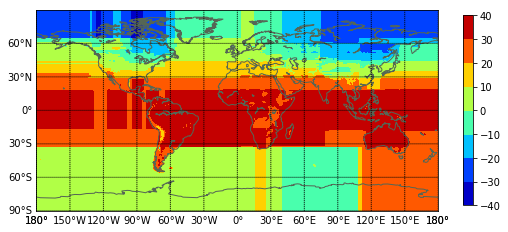

In [156]:
# make visulization
import warnings
warnings.filterwarnings('ignore')

def makedensePlot(df):
    fig, ax = plt.subplots(figsize=(9,7))
    earth = Basemap(ax=ax)
    earth.drawcoastlines(color='#556655', linewidth=1)
    earth.drawparallels(np.arange( -90., 90.,30.),labels=[1,0,0,0],fontsize=10)
    earth.drawmeridians(np.arange(-180.,180.,30.),labels=[0,0,0,1],fontsize=10)
    
    x, y = earth(df['longitude'], df['latitude'])
    z=np.array(df['tmax_pred'])
    
    ## define grid.
    xi = np.linspace(df['longitude'].min(),df['longitude'].max(),600)
    yi = np.linspace(df['latitude'].min(),df['latitude'].max(),600)
    ## grid the data.
    zi = griddata(x,y,z,xi,yi, interp='linear')
    
    CS = plt.contourf(xi,yi,zi, cmap='jet')
    fig.colorbar(ax=ax,mappable=CS, shrink=0.5)
    fig.show()

makedensePlot(predictions.toPandas())

B2: **In a separate plot show the regression error of your model predictions against test data. In this case only use locations where data is given, i.e. you may reuse your plotting method from Part 2 (a).**

In [ ]:
data = get_data(inputs)
train, test = data.randomSplit([0.7, 0.3]) #Needed for 733 A3
data_pred = model.transform(test).drop("features") #Needed for 733 A3
datanew= data_pred.toPandas()
datanew.tmax = datanew.tmax_pred - datanew.tmax

colnames = ["station","date","dayofyear","lat","lon","elevation","tmax","pred"]
datanew.columns= colnames
plotData(datanew, 'Temp Error Distribution')